In [1]:
import rioxarray as rxr
import xarray as xr
import geopandas as gpd 
import numpy as np
import earthpy.plot as ep
import earthpy.mask as em

import os
from glob import glob

In [2]:
# Define open image functions

def open_band(band_path, crop_layer=None):
    """
    Function to open and clip single band
    """
    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            img_band = rxr.open_rasterio(band_path, masked=True).rio.clip(clip_bound, from_disk=True).squeeze()
        except Exception as err:
            print(err)
    else:
        img_band = rxr.open_rasterio(band_path, masked=True).squeeze()
    return img_band


def stack_bands(paths, crop_layer=None, stack=True):
    """
    Function to open all bands and stack layers
    """    
    all_bands = []
    for i, band in enumerate(paths):
        img_band = open_band(band, crop_layer)
        img_band["band"] = i+1
        all_bands.append(img_band)
        
    if stack:
        print("Stacked all image bands")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

In [3]:
# Define cloud mask function for Landsat L2

def cloudMask_Landsat(img, BQA):
    """
    Function to mask out cloud and cloud shadow on Landsat 8 using BQA
    *** Notes
        bit 3 represents clouds
        bit 4 represents cloud shadows
    """
    cloud_bit = 1 << 3
    cloud_shadow_bit = 1 << 4
    
    cloud_mask = np.bitwise_and(BQA, cloud_bit) != 0
    cloud_shadow_mask = np.bitwise_and(BQA, cloud_shadow_bit) != 0

    # Combine cloud and cloud shadow masks
    final_mask = np.logical_or(cloud_mask, cloud_shadow_mask)

    # mask out cloud and cloud shadow 
    img_out = img.where(~final_mask.isin(1))
    
    return img_out

In [4]:
# Open region of intests

roi = gpd.read_file('./shapefile/polys.shp')

['LC08_L2SP_129050_20230502_crop\\Band_SR_B2.TIF', 'LC08_L2SP_129050_20230502_crop\\Band_SR_B3.TIF', 'LC08_L2SP_129050_20230502_crop\\Band_SR_B4.TIF', 'LC08_L2SP_129050_20230502_crop\\Band_SR_B5.TIF', 'LC08_L2SP_129050_20230502_crop\\Band_SR_B6.TIF', 'LC08_L2SP_129050_20230502_crop\\Band_SR_B7.TIF']
Stacked all image bands


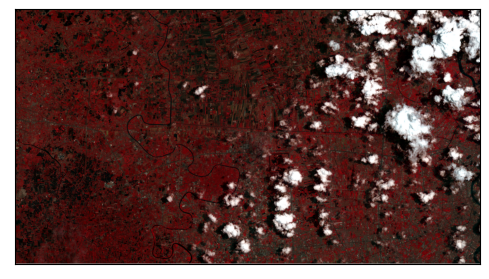

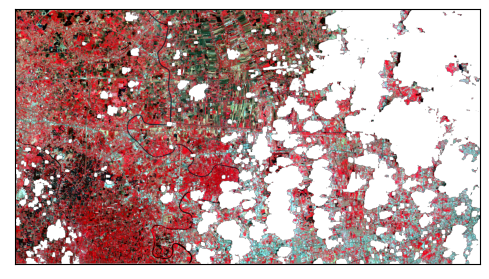

<AxesSubplot:>

In [5]:
# Generate directory of each band 

p = os.path.join("LC08_L2SP_129050_20230502_crop",
                 "*B[2-7]*.TIF")
p = sorted(glob(p))
print(p)

# Open stacked image and BQA band

img = stack_bands(p, crop_layer=roi)
bqa = open_band('./LC08_L2SP_129050_20230502_crop/Band_BQA.TIF', crop_layer=roi)

# Mask out cloud and cloud shadow
img_masked = cloudMask_Landsat(img, bqa)

# Visualization

ep.plot_rgb(img, rgb=[3,2,1], stretch='lin', figsize=(6,6))
ep.plot_rgb(img_masked, rgb=[3,2,1], stretch='lin', figsize=(6,6))

In [6]:
# Export image 
img_masked.rio.to_raster('./Out/LC08_L2SP_129050_20230502_crop_masked.tif')